# Project Description

## Motivation

<i><b>For Jan</b>: Insert business value</i>

Note: higher haplogroup resolution = more specific identification, more specific identification = more business value 


## Data Source

<i><b>For Jan</b>: Insert write up</i>

Note: https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

## Main Problem

<i><b>For Jan</b>: Insert main problem</i>

Sample: What models can be recommended that provides the highest accuracy depending on the resolution level?

## Limitations

If there is only 1 sample of a specific haplogroup, we will remove it from the dataset

Rationale: There is not enough samples to train the model and classify that specific haplogroup

# Methodology

Step 1. Identify the Business Problem

Step 2. Identify the Machine Learning Task

Step 3. Identify Key Evaluation Metrics

Step 4. Build and Test Machine Learning Models

## 1. Identify the Business Problem

<i><b>For Jan</b>: Rephrase motivation and main problem</i>

## 2. Identify the Machine Learning Task

What will the machine learning model do?
- Goal is to predict the class label (i.e. haplogroup) choice from a predefined list of states (i.e. 27 Y-STRs)

Classification Problem
- Input: Y-STRs (e.g Column DYS576, Column DYS627)
- Output: Haplogroups (i.e. Column haplogroup)

Since this is a classification problem, the following models will be utilized.
1. KNN
2. LDA
4. Gaussian Naive Bayes
5. Decision Tree
6. Random Forest
7. Gradient Boosting

For KNN, scaling will be applied during the data preprocessing to help with faster convergence, equal feature contribution, and improved performance [2][3].

Note that Logistic Regression (L1, L2) will not be used because the dataset includes classes (i.e. Haplogroups) that only occur once. One of the limitations of Logistic Regression is that overfitting may occur if the number of observations is less than the number of features [4]. Given the nature of the dataset, the ValueError "This solver needs samples of at least 2 classes in the data, but the data contains only one class" was raised, indicating that there are instances where there is insufficient samples for a particular class to train the model.

SVM will also not be used because the dataset has overlapping classes [5]. As an example, plotting two of the features (i.e. DYS627 and DYS576) show overlaps between the four haplogroups (i.e. R1a1a1b2a2, O2a2b1a1a1, O2a2a1, O2a2b1a2a1) as seen in 4.1 EDA

## 3. Identify Key Evaluation Metrics

<i><b>For Jan</b>: What evaluation metric will we use? If we will use Accuracy, explain why we will use Accuracy as the evalutation metric.

We also need to look for any industry benchmarks on Accuracy. Otherwise, we can proceed to using PCC.</i>

Evaluation Metrics: Classification
- Accuracy: use when the goal is to minimize the overall error state
- Precision: use when the cost of false positives is high
- Recall: use when the cost of false negatives is high
- F1-score: use if you want to optimize precision and recall at the same time

### PCC for Benchmark

## 4. Build and Test Machine Learning Models

In [23]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

### 4.1 Data Preprocessing

In [3]:
# Step 1. Load dataset
df = pd.read_excel('Supplemental Processed Data Set.xlsx', sheet_name='S Table 1', skiprows=1)
df

,haplogroup,number of haplotypes,haplotype,total frequency,sampleID,population,frequency
0,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 31.0, 22.0, 10.0, 17.0, 16....",1.0,HLM100,Hulunbuir[Mongolian],1.0
1,NaN,NaN,"[19.0, 14.0, 22.0, 30.0, 22.0, 10.0, 18.0, 17....",1.0,HHM158,Hohhot[Mongolian],1.0
2,NaN,NaN,"[18.0, 14.0, 21.0, 31.0, 24.0, 10.0, 17.0, 16....",1.0,ODM030,Ordos[Mongolian],1.0
3,NaN,NaN,"[19.0, 14.0, 22.0, 30.0, 20.0, 10.0, 18.0, 17....",1.0,HLM178,Hulunbuir[Mongolian],1.0
4,O2a2b1a1a1a4a1,6.0,"[18.0, 12.0, 20.0, 29.0, 19.0, 9.0, 18.0, 14.0...",1.0,HHM088,Hohhot[Mongolian],1.0
...,...,...,...,...,...,...,...
4059,NaN,NaN,"[20.0, 12.0, 20.0, 28.0, 21.0, 10.0, 15.0, 15....",1.0,HaiN153(Han),Han,1.0
4060,NaN,NaN,"[18.0, 12.0, 21.0, 28.0, 21.0, 10.0, 17.0, 15....",1.0,GD-16(Han),Han,1.0
4061,NaN,NaN,"[19.0, 12.0, 21.0, 28.0, 21.0, 10.0, 18.0, 16....",1.0,JX-82(Han),Han,1.0
4062,NaN,NaN,"[16.0, 14.0, 21.0, 29.0, 22.0, 11.0, 16.0, 15....",1.0,HaiN139(Han),Han,1.0


In [4]:
# Step 2. Fill NaN values
df = df.ffill()
df

,haplogroup,number of haplotypes,haplotype,total frequency,sampleID,population,frequency
0,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 31.0, 22.0, 10.0, 17.0, 16....",1.0,HLM100,Hulunbuir[Mongolian],1.0
1,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 30.0, 22.0, 10.0, 18.0, 17....",1.0,HHM158,Hohhot[Mongolian],1.0
2,C2b1a1a,4.0,"[18.0, 14.0, 21.0, 31.0, 24.0, 10.0, 17.0, 16....",1.0,ODM030,Ordos[Mongolian],1.0
3,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 30.0, 20.0, 10.0, 18.0, 17....",1.0,HLM178,Hulunbuir[Mongolian],1.0
4,O2a2b1a1a1a4a1,6.0,"[18.0, 12.0, 20.0, 29.0, 19.0, 9.0, 18.0, 14.0...",1.0,HHM088,Hohhot[Mongolian],1.0
...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,"[20.0, 12.0, 20.0, 28.0, 21.0, 10.0, 15.0, 15....",1.0,HaiN153(Han),Han,1.0
4060,O2a1c1a1a1,14.0,"[18.0, 12.0, 21.0, 28.0, 21.0, 10.0, 17.0, 15....",1.0,GD-16(Han),Han,1.0
4061,O2a1c1a1a1,14.0,"[19.0, 12.0, 21.0, 28.0, 21.0, 10.0, 18.0, 16....",1.0,JX-82(Han),Han,1.0
4062,O2a1c1a1a1,14.0,"[16.0, 14.0, 21.0, 29.0, 22.0, 11.0, 16.0, 15....",1.0,HaiN139(Han),Han,1.0


In [5]:
# Step 3. Split haplotype into separate columns
df = pd.concat([df, df['haplotype'].str.replace('[', '').str.replace(']', '').str.split(',', expand=True)], axis=1)
YSTRs = {0: "DYS576", 1: "DYS389 I", 2: "DYS635", 3: "DYS389 II", 4: "DYS627", 5: "DYS460", 6: "DYS458",
                 7: "DYS19", 8: "Y-GATA-H4", 9: "DYS448", 10: "DYS391", 11: "DYS456", 12: "DYS390", 13: "DYS438", 
                 14: "DYS392", 15: "DYS518", 16: "DYS570", 17: "DYS437", 18: "DYS385a", 19: "DYS385b", 20: "DYS449", 
                 21: "DYS393", 22: "DYS439", 23: "DYS481", 24: "DYS576a", 25: "DYS576b", 26: "DYS533"
}

df = df.rename(columns=YSTRs)
df = df.drop(columns=['haplotype'])
df

,haplogroup,number of haplotypes,total frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS437,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,16.0,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,14.0,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,14.0,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,14.0,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,14.0,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0


### 4.2 EDA

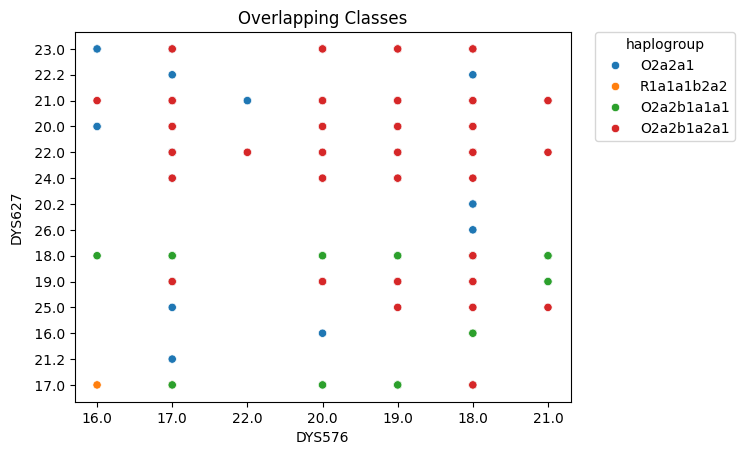

In [19]:
df_sample = df[(df['haplogroup'] == 'R1a1a1b2a2') | 
               (df['haplogroup'] == 'O2a2b1a1a1') | 
               (df['haplogroup'] == 'O2a2a1') | 
               (df['haplogroup'] == 'O2a2b1a2a1')]

df_sample = df_sample.drop(columns=['number of haplotypes', 'total frequency', 'sampleID','population','frequency'])
df_sample

ax = sns.scatterplot(data=df_sample, x='DYS576', y='DYS627', hue='haplogroup')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title('Overlapping Classes')
plt.show()

In [ ]:
# PCC for benchmark

haplogroup_df = pd.DataFrame(df['haplogroup'].value_counts())
haplogroup_df['proportions'] = haplogroup_df['count'] / (haplogroup_df['count'].sum())
haplogroup_df['proportions^2'] = haplogroup_df['proportions']**2
pcc = haplogroup_df['proportions^2'].sum()
pcc_125 = pcc*1.25
print(f'1.25 PCC: {pcc_125:.4f}')

1.25 PCC: 0.0140


### 4.3 Build ML Models

#### KNN

In [20]:
Number_trials = 20

def train_knn(X, y):
    start_time = time.time()
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        neighbors_settings = range(1,70)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)
            acc_train.append(knn.score(X_train, y_train))
            acc_test.append(knn.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA',run_time]

In [24]:
X = df.iloc[:, 6:]
y = df.iloc[:, 0]

knn_df = train_knn(X,y)
print(knn_df)

['kNN', np.float64(0.5878444881889764), 'N_Neighbor = 1', 'NA', 121.83975386619568]


#### LDA

In [41]:
Number_trials = 20

def train_lda(X, y):
    start_time = time.time()
    solvers = ['svd', 'lsqr', 'eigen']
    score_train = []
    score_test = []
    coefs = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        acc_train = []
        acc_test = []

        for s in solvers:
            lda = LinearDiscriminantAnalysis(solver=s).fit(X_train, y_train)
            acc_train.append(lda.score(X_train, y_train))
            acc_test.append(lda.score(X_test, y_test))
            if hasattr(lda, 'coef_'):
                coefs.append(lda.coef_)

        score_train.append(acc_train)
        score_test.append(acc_test)

    #mean_coefs = np.mean(coefs, axis=0)
    score = np.mean(score_test, axis=0)
    #coef_flat = np.abs(mean_coefs).flatten()
    #top_idx = np.argmax(coef_flat) % X.shape[1]
    #top_predictor = X.columns[top_idx]

    run_time = (time.time() - start_time)
    #return ['LDA', np.amax(score), f'solver = {solvers[np.argmax(score)]}', top_predictor, run_time]
    return ['LDA', np.amax(score), f'solver = {solvers[np.argmax(score)]}', 'NA', run_time]

In [42]:
X = df.iloc[:, 6:]
y = df.iloc[:, 0]

lda_df = train_lda(X, y)
print(lda_df)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covarian

['LDA', np.float64(0.5834153543307086), 'solver = svd', 'NA', 3.384709119796753]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covarian

### Gaussian Naive Bayes

In [44]:
Number_trials = 20
def train_gaussian_nb(X, y):
    start_time = time.time()
    varsmooth = [1e-9, 1e-8, 1e-7, 1e-6]
    score_train = []
    score_test = []
    means = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
        acc_train = []
        acc_test = []

        for v in varsmooth:
            nb = GaussianNB(var_smoothing=v).fit(X_train, y_train)
            acc_train.append(nb.score(X_train, y_train))
            acc_test.append(nb.score(X_test, y_test))
            means.append(nb.theta_)  # class means per feature

        score_train.append(acc_train)
        score_test.append(acc_test)

    #mean_means = np.mean(means, axis=0)
    score = np.mean(score_test, axis=0)
    #top_predictor = X.columns[np.argmax(np.abs(mean_means).mean(axis=0))]

    run_time = (time.time() - start_time)
    return ['Gaussian NB', np.amax(score), f'var_smoothing = {varsmooth[np.argmax(score)]}', 'top_predictor', run_time]

In [45]:
X = df.iloc[:, 6:]
y = df.iloc[:, 0]

gnb_df = train_gaussian_nb(X, y)
print(gnb_df)

['Gaussian NB', np.float64(0.4216043307086614), 'var_smoothing = 1e-06', 'top_predictor', 7.360477924346924]


# Results

In [46]:
automl_df = pd.DataFrame(columns=['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time'])

automl_df.loc[0] = knn_df
automl_df.loc[1] = lda_df
automl_df.loc[2] = gnb_df

automl_df = automl_df.drop(columns='Top Predictor Variable')
automl_df

,Machine Learning Method,Test Accuracy,Best Parameter,Run Time
0,kNN,0.587844,N_Neighbor = 1,121.839754
1,LDA,0.583415,solver = svd,3.384709
2,Gaussian NB,0.421604,var_smoothing = 1e-06,7.360478


Note:
- GBM is prone to overfitting
- Consider doing a confusion matrix?? For random forest, check where mistakes/confusions were made

# Recommendations

# References

[1] https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

[2] https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35/#:~:text=IN%20DEPTH%20ANALYSIS,scaling%20in%20the%20X%2DY%20plane.

[3] https://www.geeksforgeeks.org/machine-learning/Feature-Engineering-Scaling-Normalization-and-Standardization/

[4] https://www.geeksforgeeks.org/data-science/advantages-and-disadvantages-of-logistic-regression/

[5] https://medium.com/@haj122/when-and-when-not-to-use-svms-e9edea04d6ba